In [48]:
import operator, time, textwrap, dotenv

dotenv.load_dotenv()

from langchain.chat_models import init_chat_model
from langgraph.types import Send
from typing_extensions import Annotated

from langgraph.graph import END, START, StateGraph
from typing import TypedDict
import subprocess

# 오픈 AI 직접 사용 하는 방식.
from openai import OpenAI

llm = init_chat_model("openai:gpt-4o-mini")


class State(TypedDict):
    video_file: str
    audio_file: str
    transcription: str
    summaries: Annotated[list[str], operator.add]


def extract_audio(state: State):
    return
    output_file = state["video_file"].replace(".mp4", ".mp3")
    command = [
        "ffmpeg",
        "-i",
        state["video_file"],
        "-filter:a",
        "atempo=2.0",
        "-y",
        output_file,
    ]
    subprocess.run(command)
    return {
        "audio_file": output_file,
    }


def transcribe_audio(state: State):
    return
    client = OpenAI()
    with open(state["audio_file"], "rb") as audio_file:
        transcription = client.audio.transcriptions.create(
            model="whisper-1",
            response_format="text",
            file=audio_file,
            language="ko",
            prompt="유발하라리, 넥서스, 책 요약"
        )
        return {
            "transcription": transcription
        }


def dispatch_summarizers(state: State):
    transcription = state["transcription"]
    chunks = []
    for i, chunk in enumerate(textwrap.wrap(transcription, 500)):
        chunks.append({
            "id": i + 1,
            "chunk": chunk
        })
    return [Send("summarize_chunk", chunk) for chunk in chunks]


def summarize_chunk(chunk):
    chunk_id = chunk["id"]
    chunk_text = chunk["chunk"]
    response = llm.invoke(
        f"""
        이 텍스트들을 보기좋게 요약을 해주세요. 한국어 입니다.
        텍스트: {chunk_text}
        """
    )
    summary = f"[Chunk {chunk_id}] {response.content}"
    return {
        "summaries": [summary]
    }




In [49]:
graph_builder = StateGraph(State)

(
    graph_builder

    .add_node("extract_audio", extract_audio)
    .add_node("transcribe_audio", transcribe_audio)
    .add_node("dispatch_summarizers", dispatch_summarizers)
    .add_node("summarize_chunk", summarize_chunk)

    .add_edge(START, "extract_audio")
    .add_edge("extract_audio", "transcribe_audio")
    .add_conditional_edges("transcribe_audio", dispatch_summarizers, ["summarize_chunk"])
    .add_edge("summarize_chunk", END)
)

graph = graph_builder.compile()


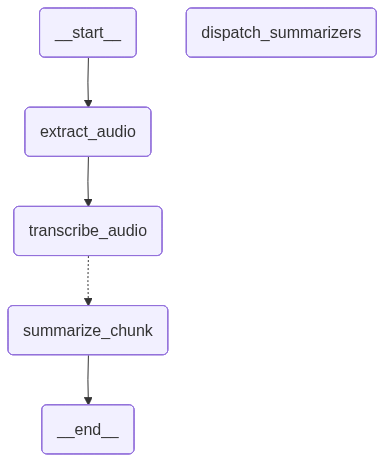

{'video_file': 'video.mp4',
 'audio_file': 'video.mp3',
 'transcription': '네, 안녕하세요. 오늘은, 오늘 책도, 오늘 아침에 읽은 책도, 여기 보이시죠? 넥서스입니다, 넥서스. 오늘도 제가 아침에 책을 읽었고요. 이렇게 1차적으로는 수첩에다가 이렇게 적습니다. 1차적으로 좋은 문장들을 적고, 이렇게 문장들을 적은 다음에 적고, 제가 챕터별로 딱 3개의 문장만 뽑아서 살짝 제 스타일대로 요약을 합니다. 요약을 하고 나서 질문 하나씩 적고, 답변을 다는 방식으로 이렇게 준비를 하고 있습니다. 지금 이틀 정도 해봤는데, 상당히 좋은 것 같아요. 책의 내용도 많이 기억에 남고, 요약을 하다보니까 더 많은 생각을 할 수 있게 되고, 그런 것 같습니다. 그래서 일단 잠깐 보시면은, 짜잔, 넥서스죠? 저번 1편에서도 보여드리긴 했는데, 이번 하루의 책이고요. 오늘은 목차를 보면은, 저번 영상에서는 프로로그를 담았고, 이번에는 정보란 무엇인가, 정보가 뭔지, 그리고 이야기, 이야기에 대한 두 장을 제가 요약을 했고요. 보시면은, 정보란 무엇인가, 여기서 인상 깊었던 구절을 제가 조금 변형해서 적어봤습니다. 책 이름이 넥서스인데, 궁극적으로는 각 개인은 서로 다른 세계관을 가지며, 그것은 그 사람의 성격과 인생사가 교차하면 형성된다. 정보란 무엇인가잖아요? 정보는 사회적 연결고리, 넥서스라는 거죠. 그러니까 종이랑 종이랑 붙이는 풀처럼 사람들을 연결해주는 그런 사회적 연결고리가 넥서스고, 그것도 정보를 정의한다고 얘기를 하는 것 같습니다. 사람들은 정말 서로 다른 세계관을 가지죠. 그래서 여러분들의 세계관은, 그 세계관에서는 무엇이 가치 있다고 생각하시는지, 그걸 한번 생각해보시면 좋을 것 같아요. 네, 두 번째입니다. 이 문장도 참 좋았는데요. 과학적이나 정치 연설 같은 몇 가지 유형의 정보는, 사람들에게 현실을 정확하게 표현해서 사람들을 하나로 묶으려고 하죠. 그런데 사람들을 묶는데 효과적인 정보는 이런 사실이 

In [50]:
display(graph)
graph.invoke({'video_file': 'video.mp4',
              'audio_file': 'video.mp3',
              'transcription': '네, 안녕하세요. 오늘은, 오늘 책도, 오늘 아침에 읽은 책도, 여기 보이시죠? 넥서스입니다, 넥서스. 오늘도 제가 아침에 책을 읽었고요. 이렇게 1차적으로는 수첩에다가 이렇게 적습니다. 1차적으로 좋은 문장들을 적고, 이렇게 문장들을 적은 다음에 적고, 제가 챕터별로 딱 3개의 문장만 뽑아서 살짝 제 스타일대로 요약을 합니다. 요약을 하고 나서 질문 하나씩 적고, 답변을 다는 방식으로 이렇게 준비를 하고 있습니다. 지금 이틀 정도 해봤는데, 상당히 좋은 것 같아요. 책의 내용도 많이 기억에 남고, 요약을 하다보니까 더 많은 생각을 할 수 있게 되고, 그런 것 같습니다. 그래서 일단 잠깐 보시면은, 짜잔, 넥서스죠? 저번 1편에서도 보여드리긴 했는데, 이번 하루의 책이고요. 오늘은 목차를 보면은, 저번 영상에서는 프로로그를 담았고, 이번에는 정보란 무엇인가, 정보가 뭔지, 그리고 이야기, 이야기에 대한 두 장을 제가 요약을 했고요. 보시면은, 정보란 무엇인가, 여기서 인상 깊었던 구절을 제가 조금 변형해서 적어봤습니다. 책 이름이 넥서스인데, 궁극적으로는 각 개인은 서로 다른 세계관을 가지며, 그것은 그 사람의 성격과 인생사가 교차하면 형성된다. 정보란 무엇인가잖아요? 정보는 사회적 연결고리, 넥서스라는 거죠. 그러니까 종이랑 종이랑 붙이는 풀처럼 사람들을 연결해주는 그런 사회적 연결고리가 넥서스고, 그것도 정보를 정의한다고 얘기를 하는 것 같습니다. 사람들은 정말 서로 다른 세계관을 가지죠. 그래서 여러분들의 세계관은, 그 세계관에서는 무엇이 가치 있다고 생각하시는지, 그걸 한번 생각해보시면 좋을 것 같아요. 네, 두 번째입니다. 이 문장도 참 좋았는데요. 과학적이나 정치 연설 같은 몇 가지 유형의 정보는, 사람들에게 현실을 정확하게 표현해서 사람들을 하나로 묶으려고 하죠. 그런데 사람들을 묶는데 효과적인 정보는 이런 사실이 아니고, 허구인 매력적인 정보가 오히려 사람들에게 잘 퍼지고, 사람들을 잘 묶는다는 얘기죠. 그래서 좋은 정보는, 정보를 사람들을 묶는 매개체로 생각해본다고 하면은, 좋은 정보는 정확한 정보가 아닐 때가 많다는 거죠. 그래서 여러분들에게 허구로 보이지만, 저거 진짜 거짓말인데, 그것도 많은 사람들이 함께 믿고 있는 정보가 있다면 뭐가 있을지 생각해보시면 좋을 것 같아요. 네, 다음입니다. 결국 역사적으로 보면, 지금 호모사피엔스가 다른 종들을 다 정복하고, 상당한 힘을 가지고 있잖아요. 그 호모사피엔스가 세계를 정복한 이유는, 거짓, 오류, 환상을 믿는 능력을 바탕으로 많은 개개인들이 연결되어 개인이 할 수 없는 거대한 일을 할 수 있었기 때문이다. 이런 문장도 중요하죠. 그래서 저도 20대 때 종교단체에 오래 있었는데, 때는 외롭지 않았어요. 신화를 바탕으로 많은 사람들이 항상 만났기 때문에 외롭지 않았는데, 점점 종교에 나오고, 진실을 추구하고, 과학을 공부하면서 외로워지는 부분이 있는 것 같아요. 그럼에도 계속 진실을 추구해야 하는 이유는 여러분들은 뭐라고 생각하시는지, 혹은 비록 거짓일지라도, 외로움보다는 거짓대로 사는 것이 나은 것인지, 이런 부분들을 좀 생각해보시면 좋을 것 같습니다. 그래서 정보란 무엇인가? 다음에서 세 가지 질문을 뽑아봤고요. 그래서 정보, 정보란 무엇일까? 이 책에서 정보라는 키워드를 많이 다루는데, 정보는 이제 사람들은 결국 나랑 만날 사람, 내가 이 사람을 만나야 될지, 아니면 만나지 말아야 될지, 그걸 판단하는 데 필요한 게 정보잖아요. 나랑 가치관이 비슷하면 계속 만나는 게 편하고, 나와 가치관이 다르면 계속 상대를 설득해야 되고, 그런 측면에서 정보, 정보는 사람들을 묵는데 접촉대 같은 역할을 하는 것이고, 그걸 넥서스라고 부른다. 이렇게 보시면 될 것 같아요. 물론 당연히 저자의 의도와는 다를 수 있는데, 저는 그렇게 읽게 되었습니다. 그리고 챕터 두 번째 것도 읽게 되었는데요, 다시 한번 같이 볼게요. 챕터 2, 그래서 여러 가지 정보들이 있는데, 이야기, 드라마나 이런 것처럼, 이야기가 그런 수많은 사람들을 무한하게 연결시킨다, 이런 챕터이고요. 여기도 정말 좋은 문장들이 많았는데, 딱 세 개만 제가 편집해서 뽑아봤습니다. 얼마나 무한하냐면, 가톨릭 교회는 44억 명 정도가 어떤 하나의 스토리를 공유해서 연결이 됐고, 그리고 세계무용망은 80억 모든 사피엔스를 연결한다. 그래서 세계무용망을 연결한 장치는 화폐, 기업, 상표에 관련된 이야기들이다. 저 80억에 저도 들어가 있습니다. 저도 이제 자본주의에 살고 있잖아요. 그래서 당연히 화폐, 기업, 상표에 관련된 이야기를 믿고 있는데, 여러분들도 화폐, 기업, 상표에 관련된 이야기들을 믿고 계신지 한번 생각해보시면 좋을 것 같아요. 그리고 사람들을 결속시키는 허구적인 정보는 진실에 비해 두 가지 고유한 이점을 가지고 있다. 허구는 간단하고 진실은 복잡할 때가 많다. 진실은 고통스럽고 불편한데, 허구는 매력적이다. 이것도 많은 생각을 하게 되는 문장인 것 같은데요. 예를 들면 다이어트를 한다고 했을 때, 다이어트를 하는 방법은 정말 고통스럽죠. 먹고 싶은 거 참아야 되고, 하기 싫은 운동을 해야 되고, 매우 힘들죠. 그런데 사람들이 많이 열광하는 다이어트 방식은 힘 안 들이고 다이어트하는 방법, 이런 것들이죠. 많은 사람들이 거기에 많이 끌리고 돈을 쓰는데, 장기적으로 더 고통이죠. 그리고 종교도 마찬가지죠. 종교도 진실을 내가 다 이해하고 개개인적으로 선택하려면 힘든데, 종교에서는 종교의 가르침을 잘 따르면 좋은 결과가 나온다고 확정을 해주니까 참 편하죠. 그래서 진실이 고통스러울 때가 많아요. 그래서 꼭 진실이 좋지는 않다는 생각이 들고, 진실이 잘 퍼지지도 않고, 그런 것 같습니다. 그리고 사람들이 진실에 불안할 정도로 다가가려고 하면, 사회는 진실을 제한하여 질서를 유지할 것이다. 많은 정부와 교회가 지하교육을 금지하여 질서를 위해 진실을 희생하는 쪽을 선택하는 이유다. 이것들도 그런 경우가 많이 있죠. 미성년자들이 보지 말아야 하는 영화들 이런 것도 있잖아요. 그리고 민감한 주제들이긴 한데, 질서 유지를 위해서 그냥 거짓말인 줄 알면서도 넘어가는 그런 진실들도 있죠. 그런 게 뭐가 있는지에 대해서 이야기를 좀 나눠보면 좋을 것 같아요. 그래서 이런 인사이트를 주는 문장들이 많이 있습니다. 그래서 세 가지 질문 여러분들 한번 적어보시면 좋을 것 같습니다. 그래서 저도 여기 노션 페이지에 적고 있어요. 그 이전에 프롤로그 했던 질문이 있고, 이거는 유튜브 밑에 링크를 알아드릴 텐데, 좋았던 문장 적고 질문 세 가지 적으면서 답변을 적어봤으니까요. 관심 있는 분들은 한번 읽어주시면 좋을 것 같고요. 그래서 다 제 생각을 적은 거기 때문에 여러분들 생각이 당연히 다를 수 있을 것 같아요. 중요한 건 이런 질문들을 하고 고민해보는 이런 습관들은 중요한 것 같습니다. 그리고 이제 주말마다 책을 읽기 때문에 다음 주 주말에 이 후의 이야기들을 한번 읽어보고 정리를 해보겠습니다. 그래서 지금 유튜브 두 번째인데요. 확실히 첫 번째 보다는 조금 더 말을 잘하는 것 같아요. 점점 발전하겠죠? 지금 넥서스 책을 읽는데 저는 너무 지금 내용이 좋은 것 같아요. 아무래도 제가 이전 작들을 다 읽어서 그런지 생각할 것들이 많고, 예전 기억들도 다시 회상이 되고 하는 것 같습니다. 그래서 앞으로 주말에 아침에 책을 읽고, 요약을 하고 영상으로 정리하는 이런 루틴을 한동안 유지하도록 하겠습니다. 그러면은 여기서 오늘 영상 마치겠습니다. 감사합니다. 종료\n'})